# Job Classification

Using the reuters data available in NLTK we are going to analyse the classification of the documents in the dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,pandas_profiling -g

import re
from tqdm import tqdm
import tarfile
import yaml
import watermark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

register_matplotlib_converters()                              # for pandas_profiling

CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2
pandas_profiling unknown

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-20-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 4ffecf583a224874a147bea189021da33065398d


### Constants

In [2]:
Output_DATA = "../data/processed/reuters.csv"

### Load Data

In [3]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to /home/greg/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [4]:
from nltk.corpus import reuters

 
def collection_stats(verbose=True):
    # List of categories
    categories = reuters.categories()
    
    # Documents: a category can be requested (ex: reuters.fileids('barley'))
    documents = reuters.fileids()
    
    df = pd.DataFrame()
    df['documents'] = documents
    df['text'] = df['documents'].apply(reuters.raw)
    df['categories'] = df['documents'].apply(reuters.categories)
    
    if verbose:
        print('Reuters data:')
        print(str(df.shape[0]) + "\t documents")
 
        train_docs = list(filter(lambda doc: doc.startswith("train"), df['documents'].values))
        print(str(len(train_docs)) + "\t total train documents")

        test_docs = list(filter(lambda doc: doc.startswith("test"), df['documents'].values))
        print(str(len(test_docs)) + "\t total test documents")

        print(str(len(categories)) + "\t categories\n")
 
        # Words for a document
        document_id = df['documents'][0]

        document_words = reuters.words(document_id)
        print('Words for doc 0:')
        print(document_words[:50]);  

        # Raw document
        print('\nRaw doc:')
        print(reuters.raw(document_id)[:150])
        
    return df, categories


In [5]:
df, categories = collection_stats()

Reuters data:
10788	 documents
7769	 total train documents
3019	 total test documents
90	 categories

Words for doc 0:
['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.', 'They']

Raw doc:
ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exportin


In [6]:
df.head(3)

,documents,text,categories
0,test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade]
1,test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain]
2,test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 3 columns):
documents     10788 non-null object
text          10788 non-null object
categories    10788 non-null object
dtypes: object(3)
memory usage: 252.9+ KB


In [8]:
df.describe()

,documents,text,categories
count,10788,10788,10788
unique,10788,10657,468
top,training/2965,26-FEB-1987\n 26-FEB-1987\n\n,[earn]
freq,1,7,3923


In [9]:
base = np.zeros(len(categories))
def count_categories(cat, cat_list=categories, base=base):
    base = base.copy()
    for x in cat:
        idx = cat_list.index(x)
        base[idx] += 1
    return base

In [10]:
cat_by_freq = df.categories.apply(count_categories).sum(axis=0)

In [11]:
df_categories = pd.DataFrame({'categories': categories, 'frequency': cat_by_freq})
df_categories.sort_values(by=['frequency'], ascending=False, inplace=True)
df_categories[:10]

,categories,frequency
21,earn,3964.0
0,acq,2369.0
46,money-fx,717.0
26,grain,582.0
17,crude,578.0
84,trade,485.0
34,interest,478.0
71,ship,286.0
86,wheat,283.0
12,corn,237.0


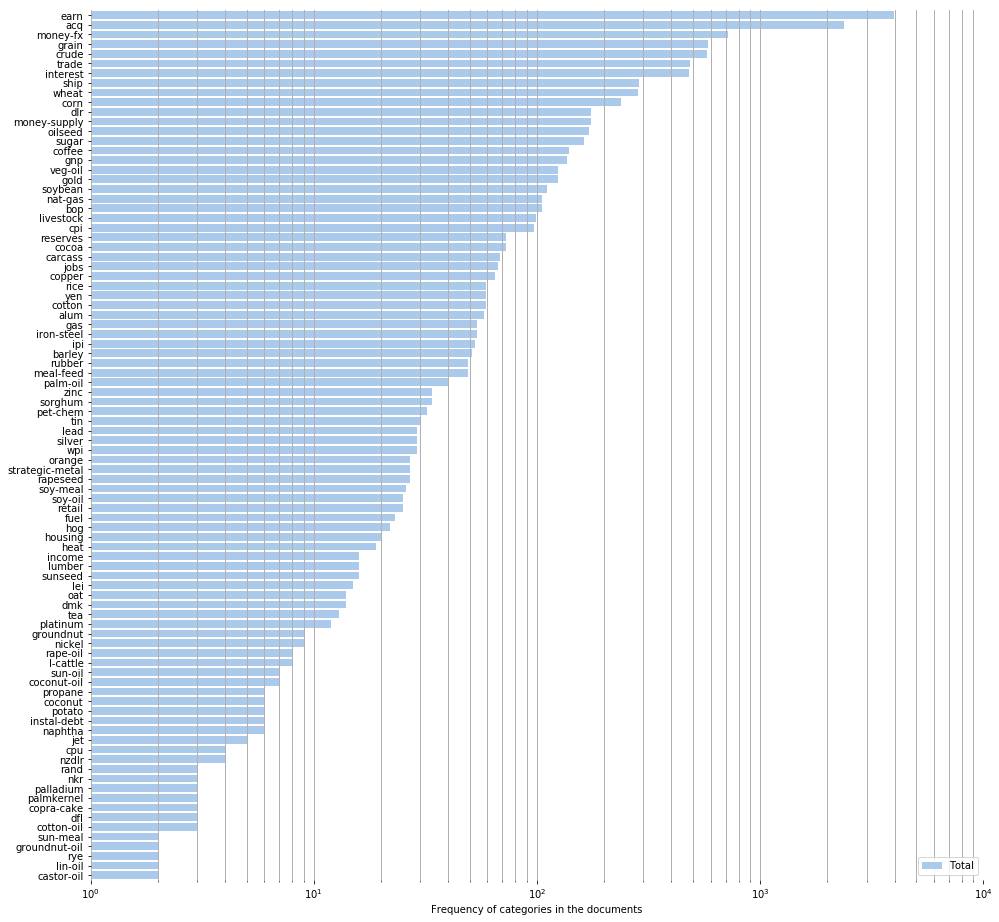

In [13]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))
# Log scale
ax.set_xscale('log')

# Plot the total crashes
sns.set_color_codes("pastel")
g = sns.barplot(x="frequency", y="categories", data=df_categories,
            label="Total", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(1, 10000), ylabel="", xlabel="Frequency of categories in the documents")
ax.grid(linestyle='-', linewidth=1, which='both', axis='x')
sns.despine(left=True, bottom=True)

In [16]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from wordcloud import WordCloud

nltk.download('wordnet')

stop_word_list = stopwords.words('english')
stop_word_list.remove('no')
stop_word_list.remove('not')

lemma = WordNetLemmatizer()
token = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/greg/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [24]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"I'm", 'I am ', text)
    text = re.sub(r"\'s", ' ', text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'", " ", text)
    text = re.sub(r"@", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"let\'s", "let us", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"y\'all", "you all", text)
    text = re.sub(r"doin\'", "doing", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = text.replace("\n", " ")
    # Extend with other cleaning text operations...
    return text

In [19]:
# Function to remove accents and normalize the text
def remove_accents(data):
    data = unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return data

In [20]:
# Remove special characters and digits
def remove_special(text):
    str = "`1234567890-=~@#$%^&*()_+[!{;”:\’'><.,/?”}]"
    for w in text:
        if w in str:
            text = text.replace(w, ' ')
    return text

# Reduce variations for inflections and derivations
def lemitize_words(text):
    words = token.tokenize(text)
    listLemma = []
    for w in words:
        x = lemma.lemmatize(w, 'v')
        listLemma.append(x)
    return text

def remove_stop_words(text):
    word_list = [x.lower().strip() for x in token.tokenize(text)]
    removedList = [x for x in word_list if not x in stop_word_list]
    text = ' '.join(removedList)
    return text

In [21]:
def text_pre_process(text):
    text = remove_accents(text)
    text = remove_special(text)
    text = lemitize_words(text)
    text = remove_stop_words(text)
    return(text)

In [26]:
df['processed_text'] = df['text'].map(lambda t: clean_text(t))
df['processed_text'] = df['processed_text'].map(lambda t: text_pre_process(t))

### Visual Representation of the words

In [27]:
all_text = ''
for x in df['processed_text']:
    ps = text_pre_process(x)
    all_text = all_text + ' ' + ps

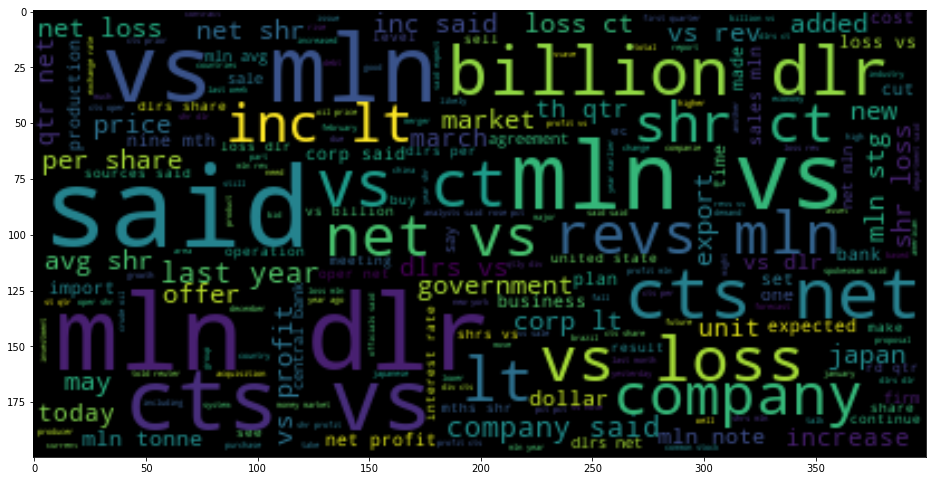

In [28]:
wc = WordCloud(background_color='black', max_font_size=50).generate(all_text)
plt.figure(figsize=(16, 12))
plt.imshow(wc, interpolation='bilinear')

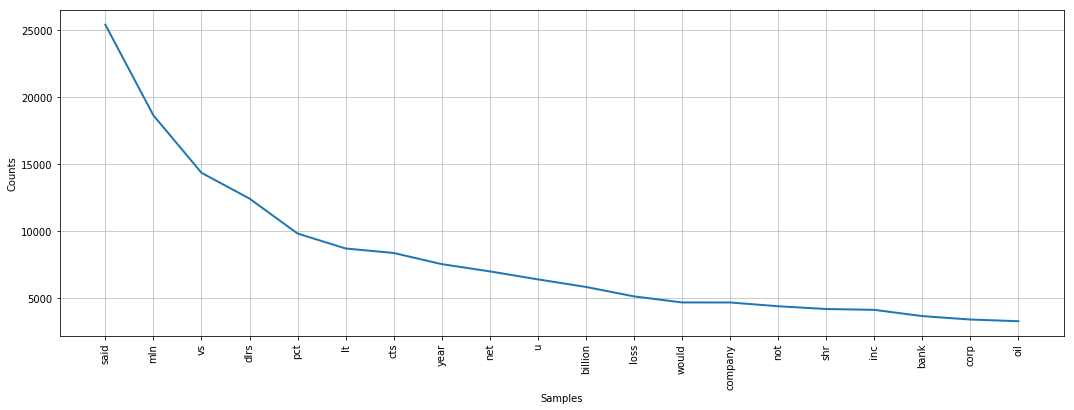

In [29]:
word_freq_dist = nltk.FreqDist(ToktokTokenizer().tokenize(all_text))
plt.figure(figsize=(18, 6))
word_freq_dist.plot(20)

### Extract features vectors